In [154]:
# 导入库函数
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigs

In [155]:
# LPP算法函数

# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(n, distances): 
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

# 以将距离从小到大排序后的第k个距离作为每个数据点的半径
def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    for i in range(n):
        # 选取第k个距离作为半径
        radius[i] = sorted_distances[i, k]
    return radius

def knn_graph(Data, method, k):
    n = Data.shape[1]  # 修改此处获取样本点的数量
    knn_adjacency_matrix = np.zeros((n, n))  
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) # 修改计算欧式距离矩阵的方式
    if method == 'epsilon':
        return knn_adjacency_matrix, distances
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    for i in range(n):
        knn_adjacency_matrix[i, indices[i]] = 1
        knn_adjacency_matrix[indices[i], i] = 1
    return knn_adjacency_matrix, distances

def compute_avg_radius(n, distances): 
    radius = np.zeros(n)
    for i in range(n):
        avg_radius = np.mean(distances[:, i])  # 修改计算每个数据点的平均邻域半径的方式
        radius[i] = avg_radius
    return radius

def compute_k_maximun_radius(n, distances, k):
    radius = np.zeros(n)
    sorted_distances = np.sort(distances, axis=0)  # 修改对距离矩阵的每一列进行排序
    for i in range(n):
        radius[i] = sorted_distances[k, i]  # 修改选取第k个距离作为半径的方式
    return radius

def compute_neighborhood_matrix(Data, method, k):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        return knn_adjacency_matrix, distances
    adjacency_matrix = np.zeros((n, n))
    radius = compute_k_maximun_radius(n, distances, k)
    for i in range(n):
        neighbors = np.where(distances[:, i] <= radius[i])[0]  # 修改获取epsilon邻域内的样本索引的方式
        adjacency_matrix[i, neighbors] = 1
        adjacency_matrix[neighbors, i] = 1
    return adjacency_matrix, distances

def construct_weight_matrix(Data, method, k, t):
    n = Data.shape[1]  # 修改获取样本点的数量的方式
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, k)
    similarity_matrix = np.exp(-distances ** 2 / t)
    i_indices, j_indices = np.where(adjacency_matrix == 1)
    Weight_matrix[i_indices, j_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix[j_indices, i_indices] = similarity_matrix[i_indices, j_indices]
    Weight_matrix += np.exp(-distances ** 2 / t)
    return Weight_matrix

In [156]:
# MLDA算法函数

# 计算每个类别的均值矩阵
def compute_classes_mean_matrix(train_data, train_labels):
    num_classes = len(np.unique(train_labels))  # 类别数量
    num_samples_per_class = train_data.shape[0] // num_classes  # 每个类别的样本数
    num_features = train_data.shape[1]  # 每个样本的特征维度
    means = np.zeros((num_classes, num_features))  # 存储每个类别的均值矩阵
    for i in range(1, num_classes + 1):  # 遍历每个类别
        temp_indices = np.where(train_labels == i)[0]  # 获取当前类别的训练数据索引
        temp_sum = np.sum(train_data[temp_indices], axis=0)  # 计算当前类别的特征值总和
        means[i-1] = temp_sum / num_samples_per_class  # 计算当前类别的均值
    return means  # 返回每个类别的均值矩阵
"""
# 计算所有类别的整体均值矩阵
def compute_overall_mean_matrix(classes_means):
    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值
    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）

# 计算中心类别矩阵
def compute_center_class_matrix(train_data, train_labels, classes_means):
    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵
    
    for i in range(train_data.shape[0]):  # 遍历训练数据
        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引
        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵
        
    return Z  # 返回中心类别矩阵

# 计算类间散布矩阵
def compute_between_class_scatter_matrix(classes_means, overall_mean):
    n = 5  # 训练集与测试集的比例
    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵
    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵
        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵
    return Sb  # 返回类间散布矩阵

# 计算类内散布矩阵
def compute_class_scatter_matrix(Z):
    Sw = np.dot(Z.T, Z)  # 计算类内散布矩阵
    return Sw  # 返回类内散布矩阵
"""

'\n# 计算所有类别的整体均值矩阵\ndef compute_overall_mean_matrix(classes_means):\n    overall_mean = np.mean(classes_means, axis=0)  # 计算所有类别的整体均值\n    return overall_mean.reshape(-1, 1)  # 返回整体均值矩阵（转置）\n\n# 计算中心类别矩阵\ndef compute_center_class_matrix(train_data, train_labels, classes_means):\n    Z = np.zeros_like(train_data)  # 初始化中心类别矩阵\n    \n    for i in range(train_data.shape[0]):  # 遍历训练数据\n        class_index = int(train_labels[i]) - 1  # 获取当前样本所属类别的索引\n        Z[i] = train_data[i] - classes_means[class_index]  # 计算中心类别矩阵\n        \n    return Z  # 返回中心类别矩阵\n\n# 计算类间散布矩阵\ndef compute_between_class_scatter_matrix(classes_means, overall_mean):\n    n = 5  # 训练集与测试集的比例\n    Sb = np.zeros((classes_means.shape[1], classes_means.shape[1]))  # 初始化类间散布矩阵\n    for i in range(classes_means.shape[0]):  # 遍历每个类别的均值矩阵\n        Sb = np.add(Sb, n * ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))  # 计算类间散布矩阵\n    return Sb  # 返回类间散布矩阵\n\n# 计算类内散布矩阵\ndef compute_class_scatter_matrix

In [157]:
def ShowEigenface(eigenfaces, faceshape):
    # 显示前16个特征脸
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 10))
    for i in range(16):
        axes[i%4][i//4].imshow(eigenfaces[:, i].reshape(faceshape), cmap="gray")
    plt.show()

In [158]:
def LPP(Data, d, method, k, t):
    Data = Data.T
    Weight_matrix = construct_weight_matrix(Data, method, k, t)
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    """
    objective_value = np.dot(np.dot(Data, Laplacian_matrix), Data.T)  # 计算目标函数
    print("目标函数值形状：", objective_value.shape)
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1, which='SR')
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]
    selected_eigenvectors = eigenvectors.real[:, selected_indices]
    """
    return Laplacian_matrix, Data

In [159]:
def MLDA(train_data, train_labels, d):
    # 计算每个类别的均值矩阵
    classes_means = compute_classes_mean_matrix(train_data, train_labels)
    """
    print('classes_means形状：', classes_means.shape)

    # 计算所有类别的整体均值矩阵
    overall_mean = compute_overall_mean_matrix(classes_means)
    print('overall_mean形状：', overall_mean.shape)

    # 计算中心类别矩阵
    Z = compute_center_class_matrix(train_data, train_labels, classes_means)
    print('Z形状：', Z.shape)

    # 计算类间散布矩阵
    Sb = compute_between_class_scatter_matrix(classes_means, overall_mean)
    print('Sb形状：', Sb.shape)

    # 计算类内散布矩阵
    Sw = compute_class_scatter_matrix(Z)
    print('Sw形状：', Sw.shape)
    """
    return classes_means.T

In [160]:
def DLPP(train_data, train_labels, d, lpp_method, k, t):
    # Step 1: 使用MLDA进行特征提取
    F = MLDA(train_data, train_labels, d)
    print("类平均脸形状:", F.shape)
    # Step 2: 使用LPP进行特征提取
    L, X = LPP(train_data, d, lpp_method, k, t)
    print("拉普拉斯矩阵形状:", L.shape)
    # Step 3: 计算权重矩阵B
    num_classes = len(np.unique(train_labels))  # 计算训练集中的类别数
    B = np.zeros((num_classes, num_classes))  # 初始化权重矩阵B
    # 遍历每对类别，计算其对应的权重
    for i in range(num_classes):  # 遍历每个类别
        for j in range(num_classes):  # 再次遍历每个类别
            if i != j:  # 如果类别不相同
                fi = F[i]  # 获取第i个类别的平均脸
                fj = F[j]  # 获取第j个类别的平均脸
                # 计算第i类别和第j类别平均脸之间的欧氏距离，并将其应用于高斯核函数，计算权重
                B[i, j] = np.exp(-np.linalg.norm(fi - fj) ** 2 / t)
    # Step 4: 计算E和H矩阵
    E = np.diag(np.sum(B, axis=1))
    H = E - B
    print("类权重矩阵形状:", B.shape)
    # Step 5: 计算目标函数的分母和分子
    denominator = np.dot(np.dot(F, H), F.T)
    print("分母形状:", denominator.shape)
    numerator = np.dot(np.dot(X, L), X.T)
    print("分子形状:", numerator.shape)
    # Step 6: 分式
    objective_value = numerator / denominator
    # Step 7: 求解广义特征值问题的特征值和特征向量
    eigenvalues, eigenvectors = eigs(objective_value, k=d+1)
    sorted_indices = np.argsort(eigenvalues.real)
    selected_indices = sorted_indices[1:d + 1]  
    selected_eigenvectors = eigenvectors.real[:, selected_indices] 
    return selected_eigenvectors

In [161]:
# 读取数据集
def read_images(dataset_dir, target_size=(32, 32)):
    data = []  # 存储图像数据的列表
    labels = []  # 存储标签的列表
    faceshape = [] # 存储图像形状
    for class_dir in os.listdir(dataset_dir):  # 遍历数据集文件夹中的文件夹（每个文件夹代表一个类别）
        class_path = os.path.join(dataset_dir, class_dir)  # 类别文件夹路径
        for file_name in os.listdir(class_path):  # 遍历每个类别文件夹中的图像文件
            file_path = os.path.join(class_path, file_name)  # 图像文件路径
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # 读取灰度图像
            # 缩放图像至目标尺寸
            img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
            # 读取第一张灰度图像的大小作为图片形状
            faceshape = img.shape
            data.append(img.flatten())  # 将图像展平并添加到数据列表中
            labels.append(int(class_dir))  # 将类别标签添加到标签列表中
    return np.array(data), np.array(labels).reshape(-1, 1), faceshape  # 返回图像数据和标签

# 训练集和测试集划分
def train_test_split(data, labels, train_test_split_ratio):
    num_samples = data.shape[0]  # 总样本数
    train_samples = int(num_samples * train_test_split_ratio)  # 训练集样本数
    
    # 洗牌算法打乱数据集
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    
    # 划分训练集和测试集
    train_data = data[:train_samples]
    train_labels = labels[:train_samples]
    test_data = data[train_samples:]
    test_labels = labels[train_samples:]
    
    return train_data, train_labels, test_data, test_labels

In [162]:
def test_image(i, faceshape, overall_mean, train_labels, train_data, test_labels, query, dlpp_eigenfaces, dlpp_weight_matrix):
    # 计算测试图像的权重向量
    query_weight = (dlpp_eigenfaces.T @ (query - overall_mean.flatten()).reshape(-1, 1))
    # 计算测试图像权重与数据集中每个人脸权重的欧氏距离
    euclidean_distances = np.linalg.norm(dlpp_weight_matrix - query_weight, axis=0)
    # 找到最佳匹配的人脸
    best_match_index = np.argmin(euclidean_distances)
    #判断是否匹配正确
    flag = True
    if train_labels[best_match_index] == test_labels[i]:
        flag = True
    else:
        flag = False
    """
    # 可视化
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 6))
    axes[0].imshow(query.reshape(faceshape), cmap="gray")
    axes[0].set_title("Query Image")
    axes[1].set_xlabel("Euclidean Distance: {:.0f}".format(euclidean_distances[best_match_index]))
    axes[1].imshow(train_data[best_match_index].reshape(faceshape), cmap="gray")
    axes[1].set_title("Best Match")
    plt.show()
    """
    return flag

类别数量： 400
图像数据形状： (400, 1024)
训练集形状： (280, 1024)
类平均脸形状: (1024, 40)


拉普拉斯矩阵形状: (280, 280)
类权重矩阵形状: (40, 40)
分母形状: (1024, 1024)
分子形状: (1024, 1024)
DLPP特征脸形状: (1024, 70)


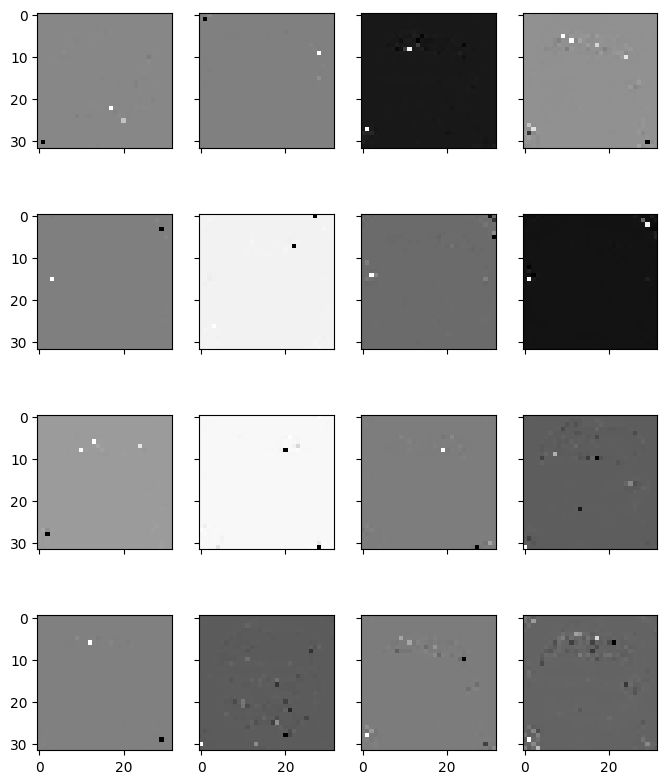

整体均值脸形状: (1024, 1)
DLPP权重矩阵形状: (70, 280)


In [163]:
dataset = "ORL"
data, labels, faceshape = read_images(dataset)
print("类别数量：", len(labels))
print("图像数据形状：", data.shape)
train_data, train_labels, test_data, test_labels = train_test_split(data, labels, train_test_split_ratio=0.7)
print("训练集形状：", train_data.shape)
d = 70
k = 5
t = 60000
lpp_method = 'knn'  # 'knn'或'epsilon'

dlpp_eigenfaces = DLPP(train_data, train_labels, d, lpp_method, k, t)
print("DLPP特征脸形状:", dlpp_eigenfaces.shape)
ShowEigenface(dlpp_eigenfaces, faceshape)

overall_mean = np.mean(train_data, axis=0).reshape(-1, 1)
print("整体均值脸形状:", overall_mean.shape)
dlpp_weight_matrix = np.dot(dlpp_eigenfaces.T, train_data.T- overall_mean)
print("DLPP权重矩阵形状:", dlpp_weight_matrix.shape)

In [164]:
# 识别率统计
wrong_times = 0
right_times = 0
for i in range(test_data.shape[0]):
    flag = test_image(i, faceshape, overall_mean, train_labels, train_data, test_labels, test_data[i], dlpp_eigenfaces, dlpp_weight_matrix)
    if flag:
                right_times += 1
    else:
        wrong_times += 1
rate = right_times / test_data.shape[0]
print(f"Recognition Rate: {rate}")

Recognition Rate: 0.9


In [165]:
"""
# 调整参数循环测试并生成结果

# 定义参数范围
d = 30
k_range = range(3000, 9001, 500)
t_range = range(500000, 1450001, 50000)
lpp_method = 'knn'

# 检查 CSV 文件是否存在
csv_filename = 'outcome.csv'
if not os.path.exists(csv_filename):
    # 如果文件不存在，创建一个新的 DataFrame
    df = pd.DataFrame(columns=['k', 't', 'rate'])
else:
    # 如果文件存在，读取已有的结果
    df = pd.read_csv(csv_filename)

# 遍历参数
iteration = 1
for k in k_range:
    for t in t_range:
        # 检查结果是否已经存在
        if ((df['k'] == k) & (df['t'] == t)).any():
            continue  # 如果结果已经存在，跳过这个参数组合
        
        # 输出当前参数信息
        print(f"Iteration {iteration}: k={k}, t={t}")
        
        # 计算 DLPP
        dlpp_weight_matrix, overall_mean = DLPP(train_data, train_labels, d, lpp_method, k, t)
        dlpp_eigenfaces = np.dot(train_data.T, dlpp_weight_matrix)
        
        # 识别率统计
        wrong_times = 0
        right_times = 0
        for i in range(test_data.shape[0]):
            flag = test_image(i, faceshape, overall_mean, train_labels, train_data, test_data, dlpp_eigenfaces, dlpp_weight_matrix)
            if flag:
                right_times += 1
            else:
                wrong_times += 1
        rate = right_times / (right_times + wrong_times)
        print(f"Recognition Rate: {rate}")
        
        # 添加结果到 DataFrame
        df = pd.concat([df, pd.DataFrame({'k': [k], 't': [t], 'rate': [rate]})], ignore_index=True)

        # 保存结果到 CSV 文件
        df.to_csv(csv_filename, index=False)
        
        # 增加迭代计数
        iteration += 1
"""

'\n# 调整参数循环测试并生成结果\n\n# 定义参数范围\nd = 30\nk_range = range(3000, 9001, 500)\nt_range = range(500000, 1450001, 50000)\nlpp_method = \'knn\'\n\n# 检查 CSV 文件是否存在\ncsv_filename = \'outcome.csv\'\nif not os.path.exists(csv_filename):\n    # 如果文件不存在，创建一个新的 DataFrame\n    df = pd.DataFrame(columns=[\'k\', \'t\', \'rate\'])\nelse:\n    # 如果文件存在，读取已有的结果\n    df = pd.read_csv(csv_filename)\n\n# 遍历参数\niteration = 1\nfor k in k_range:\n    for t in t_range:\n        # 检查结果是否已经存在\n        if ((df[\'k\'] == k) & (df[\'t\'] == t)).any():\n            continue  # 如果结果已经存在，跳过这个参数组合\n        \n        # 输出当前参数信息\n        print(f"Iteration {iteration}: k={k}, t={t}")\n        \n        # 计算 DLPP\n        dlpp_weight_matrix, overall_mean = DLPP(train_data, train_labels, d, lpp_method, k, t)\n        dlpp_eigenfaces = np.dot(train_data.T, dlpp_weight_matrix)\n        \n        # 识别率统计\n        wrong_times = 0\n        right_times = 0\n        for i in range(test_data.shape[0]):\n            flag = test_image(i